In [2]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load
from statsmodels.tsa.stattools import adfuller
import math
from math import exp

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

##Random Forest Univariado

In [4]:
dfu = pd.read_excel("data_col.xlsx")

**Preprocesamiento de los datos**

In [5]:
dfu.rename(columns = {"GDP, real, LCU":"PIB"}, inplace = True)
dfu = dfu.dropna()
dfu

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$",PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate
93,2005,1,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,120001.400283,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428
94,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280
95,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390
96,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057
97,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233
98,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,1809.702097,131941.288576,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286
99,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,1727.184623,138820.484187,0.014830,47.178122,9902.757739,9.653961,28442.963092,14567.834020,12.746544
100,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,2011.062937,151086.012462,-0.041852,47.757437,10432.746210,9.183083,23707.139541,15014.361958,11.396815
101,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,2026.281705,136263.189756,-0.010085,44.122870,11113.161091,9.752353,27924.821467,17350.077332,13.050369
102,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,2228.736352,140995.507129,0.017837,43.993533,11687.247965,9.966559,31577.479351,19727.681453,11.234133


In [6]:
dfu['date']=pd.to_datetime(dfu['year'].astype(str) + 'Q' + dfu['quarter'].astype(str))
dfu

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$",PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate,date
93,2005,1,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,120001.400283,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428,2005-01-01
94,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280,2005-04-01
95,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390,2005-07-01
96,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057,2005-10-01
97,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233,2006-01-01
98,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,1809.702097,131941.288576,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286,2006-04-01
99,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,1727.184623,138820.484187,0.014830,47.178122,9902.757739,9.653961,28442.963092,14567.834020,12.746544,2006-07-01
100,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,2011.062937,151086.012462,-0.041852,47.757437,10432.746210,9.183083,23707.139541,15014.361958,11.396815,2006-10-01
101,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,2026.281705,136263.189756,-0.010085,44.122870,11113.161091,9.752353,27924.821467,17350.077332,13.050369,2007-01-01
102,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,2228.736352,140995.507129,0.017837,43.993533,11687.247965,9.966559,31577.479351,19727.681453,11.234133,2007-04-01


In [7]:
# Index time
# ==============================================================================
SerieTiempou = dfu.set_index('date')
SerieTiempou = SerieTiempou.sort_index()
SerieTiempou.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$",PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate
date,,,,,,,,,,,,,,,,,,,
2005-01-01,2005,1,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,120001.400283,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428
2005-04-01,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280
2005-07-01,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390
2005-10-01,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233


**Normalización**

In [8]:
SerieTiempou["LPIB"] = np.log(SerieTiempou["PIB"])
SerieTiempou["DLPIB"] = SerieTiempou["LPIB"].diff()
SerieTiempou = SerieTiempou.drop(SerieTiempou.index[0])
SerieTiempou.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate,LPIB,DLPIB
date,,,,,,,,,,,,,,,,,,,,,
2005-04-01,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,...,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280,11.738437,0.043178
2005-07-01,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,...,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390,11.767058,0.028621
2005-10-01,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,...,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057,11.853823,0.086765
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,...,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233,11.756555,-0.097268
2006-04-01,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,...,131941.288576,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286,11.790112,0.033557


In [9]:
print(f'Number of rows with missing values: {SerieTiempou.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [10]:
SerieTiempou = SerieTiempou.asfreq('QS')

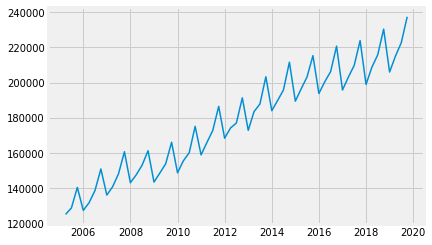

In [11]:
fig, ax = plt.subplots()
ax.plot("PIB", data =SerieTiempou)
plt.show() 

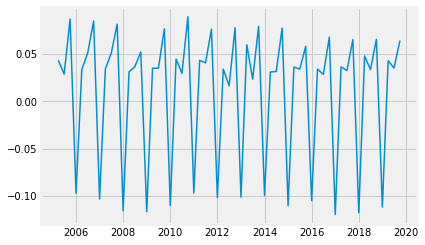

In [12]:
fig, ax = plt.subplots()
ax.plot("DLPIB", data =SerieTiempou)
plt.show()

In [13]:
adf= adfuller(SerieTiempou["DLPIB"], maxlag=1)
print("el t-test es:",adf[0])
print("el p-value es:", adf[1])
print("valores criticos:", adf[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -8.89082955314025
el p-value es: 1.2438562382298946e-14
valores criticos: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


In [14]:
# Verify that a temporary index is complete
# ==============================================================================
(SerieTiempou.index == pd.date_range(start=SerieTiempou.index.min(),
                             end=SerieTiempou.index.max(),
                             freq=SerieTiempou.index.freq)).all()

True

In [15]:
print(SerieTiempou.index.max())

2019-10-01 00:00:00


**Ajuste del conjunto de entrenamiento y validación**

Train dates : 2005-04-01 00:00:00 --- 2016-10-01 00:00:00  (n=47)
Test dates  : 2017-01-01 00:00:00 --- 2019-10-01 00:00:00  (n=12)


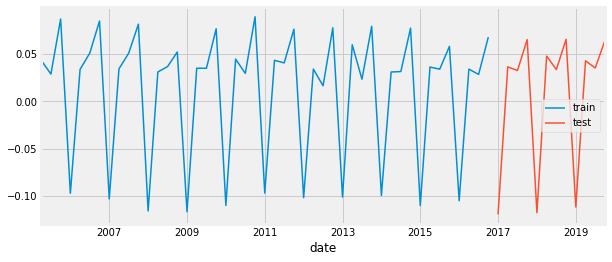

In [16]:
# Split data into train-test
# ==============================================================================
steps = 12
data_trainu = SerieTiempou[:-steps]
data_testu  = SerieTiempou[-steps:]

print(f"Train dates : {data_trainu.index.min()} --- {data_trainu.index.max()}  (n={len(data_trainu)})")
print(f"Test dates  : {data_testu.index.min()} --- {data_testu.index.max()}  (n={len(data_testu)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_trainu['DLPIB'].plot(ax=ax, label='train')
data_testu['DLPIB'].plot(ax=ax, label='test')
ax.legend();

**Entrenamiento**


In [17]:
# Create and train forecaster
# ==============================================================================
forecasteru = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=42),
                lags = 4
                )

forecasteru.fit(y=data_trainu['DLPIB'])
forecasteru

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [1 2 3 4] 
Window size: 4 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-04-01 00:00:00'), Timestamp('2016-10-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: QS-JAN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-22 06:34:48 
Last fit date: 2022-08-22 06:34:48 
Skforecast version: 0.4.3 

In [18]:
# Predictions
# ==============================================================================
steps = 12
predictionsu = forecasteru.predict(steps=steps)
predictionsu.head(15)

2017-01-01   -0.097236
2017-04-01    0.034921
2017-07-01    0.029718
2017-10-01    0.076591
2018-01-01   -0.104032
2018-04-01    0.036928
2018-07-01    0.029269
2018-10-01    0.074411
2019-01-01   -0.104604
2019-04-01    0.036107
2019-07-01    0.028388
2019-10-01    0.073065
Freq: QS-JAN, Name: pred, dtype: float64

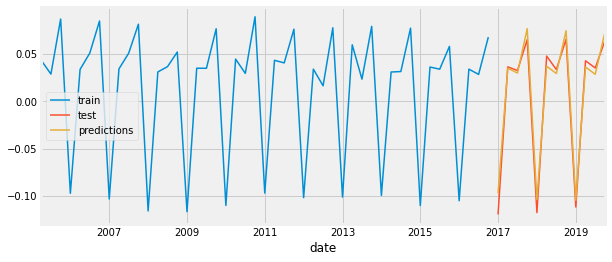

In [19]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_trainu['DLPIB'].plot(ax=ax, label='train')
data_testu['DLPIB'].plot(ax=ax, label='test')
predictionsu.plot(ax=ax, label='predictions')
ax.legend();

**Medidas de bondad de ajuste**

In [20]:
# Test error
# ==============================================================================
error_mseu = mean_squared_error(
                y_true = data_testu['DLPIB'],
                y_pred = predictionsu
            )

print(f"Test error (mse): {error_mseu}")

Test error (mse): 0.00010514492922006288


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmsu = sqrt(mean_squared_error(y_true=data_testu['DLPIB'], y_pred= predictionsu))
print(f"root mean squared error (rms): {rmsu}")

root mean squared error (rms): 0.010254020149193334


In [22]:
from sklearn.metrics import mean_absolute_error

maeu = mean_absolute_error(y_true=data_testu['DLPIB'], y_pred= predictionsu)
print(f"mean absolute error (MAE): {maeu}")

mean absolute error (MAE): 0.008738263342572458


**Ajuste de hiperparámetros**

In [23]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecasteruh = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=42),
                lags      = 6 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_griduh = [5, 10]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [1,3,7,11,17,19]}

results_griduh = grid_search_forecaster(
                        forecaster         = forecasteruh,
                        y                  = data_trainu['DLPIB'],
                        param_grid         = param_grid,
                        lags_grid          = lags_griduh,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_trainu)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 36


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:45<00:00, 52.66s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 7, 'n_estimators': 100}
  Backtesting metric: 0.00023811346833089455



In [24]:
results_griduh

,lags,params,metric,max_depth,n_estimators
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 100}",0.000238,7,100
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 19, 'n_estimators': 100}",0.000244,19,100
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 11, 'n_estimators': 100}",0.000244,11,100
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 17, 'n_estimators': 100}",0.000244,17,100
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 19, 'n_estimators': 1000}",0.000245,19,1000
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 17, 'n_estimators': 1000}",0.000245,17,1000
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 11, 'n_estimators': 1000}",0.000245,11,1000
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 1000}",0.000246,7,1000
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.000250,3,100
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 1000}",0.000258,3,1000


**Predicción con hiperparámetros**

In [25]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressoruh = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=44)
forecasteruh = ForecasterAutoreg(
                regressor = regressoruh,
                lags      = 10
             )

forecasteruh.fit(y=data_trainu['DLPIB'])

In [26]:
# Predictions
# ==============================================================================
predictionsuh = forecasteruh.predict(steps=steps)

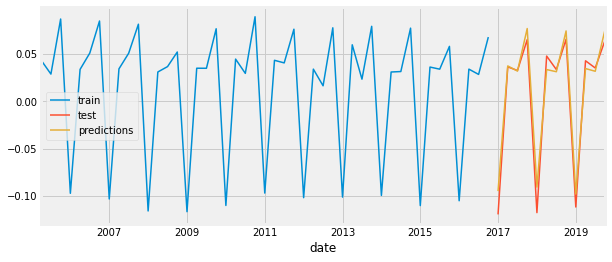

In [27]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_trainu['DLPIB'].plot(ax=ax, label='train')
data_testu['DLPIB'].plot(ax=ax, label='test')
predictionsuh.plot(ax=ax, label='predictions')
ax.legend();

In [28]:
# Test error
# ==============================================================================
error_mseuh = mean_squared_error(
                y_true = data_testu['DLPIB'],
                y_pred = predictionsuh
                )

print(f"Test error (mse): {error_mseuh}")

Test error (mse): 0.0001791376009677365


In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmsuh = sqrt(mean_squared_error(y_true=data_testu['DLPIB'], y_pred= predictionsuh))
print(f"root mean squared error (rms): {rmsuh}")

root mean squared error (rms): 0.013384229561978399


In [30]:
from sklearn.metrics import mean_absolute_error

maeuh = mean_absolute_error(y_true=data_testu['DLPIB'], y_pred= predictionsuh)
print(f"mean absolute error (rms): {maeuh}")

mean absolute error (rms): 0.010571760729618795


**Volviendo a la serie original**

In [31]:
ori_predu = np.r_[data_trainu['LPIB'][-1], predictionsuh].cumsum()
exp_ori_predu = np.exp(ori_predu)
data_testu['predfecha']=exp_ori_predu[:-1] 
print(data_testu['predfecha'])


date
2017-01-01    220751.546169
2017-04-01    200752.575439
2017-07-01    208368.865412
2017-10-01    215096.126818
2018-01-01    232246.516331
2018-04-01    212104.660134
2018-07-01    219309.841289
2018-10-01    226237.826894
2019-01-01    243661.030762
2019-04-01    220902.100505
2019-07-01    228644.285137
2019-10-01    235982.451901
Freq: QS-JAN, Name: predfecha, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


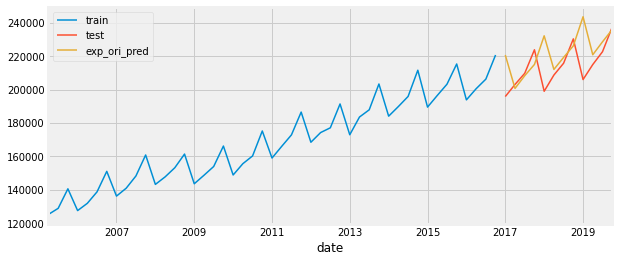

In [32]:
fig, ax = plt.subplots(figsize=(9, 4))
data_trainu['PIB'].plot(ax=ax, label='train')
data_testu['PIB'].plot(ax=ax, label='test')
data_testu['predfecha'].plot(ax=ax, label='exp_ori_pred')
ax.legend();

##Random Forest Multivariado

**Preprocesamiento de los datos**

In [33]:
#SerieTiempo.head()
dfm = pd.read_excel("data_col.xlsx")
dfm.rename(columns = {"GDP, real, LCU":"PIB"}, inplace = True)
dfm = dfm.dropna()
dfm

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$",PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate
93,2005,1,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,120001.400283,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428
94,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280
95,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390
96,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057
97,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233
98,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,1809.702097,131941.288576,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286
99,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,1727.184623,138820.484187,0.014830,47.178122,9902.757739,9.653961,28442.963092,14567.834020,12.746544
100,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,2011.062937,151086.012462,-0.041852,47.757437,10432.746210,9.183083,23707.139541,15014.361958,11.396815
101,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,2026.281705,136263.189756,-0.010085,44.122870,11113.161091,9.752353,27924.821467,17350.077332,13.050369
102,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,2228.736352,140995.507129,0.017837,43.993533,11687.247965,9.966559,31577.479351,19727.681453,11.234133


In [34]:
dfm['date']=pd.to_datetime(dfm['year'].astype(str) + 'Q' + dfm['quarter'].astype(str))
dfm

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$",PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate,date
93,2005,1,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,120001.400283,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428,2005-01-01
94,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280,2005-04-01
95,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390,2005-07-01
96,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057,2005-10-01
97,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233,2006-01-01
98,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,1809.702097,131941.288576,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286,2006-04-01
99,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,1727.184623,138820.484187,0.014830,47.178122,9902.757739,9.653961,28442.963092,14567.834020,12.746544,2006-07-01
100,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,2011.062937,151086.012462,-0.041852,47.757437,10432.746210,9.183083,23707.139541,15014.361958,11.396815,2006-10-01
101,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,2026.281705,136263.189756,-0.010085,44.122870,11113.161091,9.752353,27924.821467,17350.077332,13.050369,2007-01-01
102,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,2228.736352,140995.507129,0.017837,43.993533,11687.247965,9.966559,31577.479351,19727.681453,11.234133,2007-04-01


In [35]:
SerieTiempom = dfm.set_index('date')
SerieTiempom = SerieTiempom.sort_index()
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$",PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate
date,,,,,,,,,,,,,,,,,,,
2005-01-01,2005,1,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,120001.400283,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428
2005-04-01,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280
2005-07-01,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390
2005-10-01,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233


In [36]:
x = dfm[['Consumer price index','Consumption, government, real, LCU',	'Consumption, private, real, LCU',	'Current account of balance of payments, LCU',	'Employment, total (miles)',	'Exchange rate, period average, per Euro',	'Exchange rate, period average',	'Exports, goods & services, real, LCU',	'Foreign direct investment, US$',	'Government balance, share of GDP',	'Gross government debt (as a % of GDP)',	'Imports, goods & services, real, LCU',	'Interest rate, 10-year government bond yields',	'Investment, total fixed investment, real, LCU',	'Reserves, foreign exchange, US$', 'Unemployment rate']]
x

,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU","Foreign direct investment, US$","Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate
93,56.976667,14132.998659,81971.186018,-551.507860,16005.898333,3090.131456,2352.386667,6538.608554,880.219007,-0.021063,49.102976,7090.116415,13.285869,20054.195733,13136.775522,13.630428
94,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,1600.177049,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280
95,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,978.797932,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390
96,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,6776.223328,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057
97,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,1202.675654,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233
98,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,1809.702097,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286
99,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,1727.184623,0.014830,47.178122,9902.757739,9.653961,28442.963092,14567.834020,12.746544
100,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,2011.062937,-0.041852,47.757437,10432.746210,9.183083,23707.139541,15014.361958,11.396815
101,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,2026.281705,-0.010085,44.122870,11113.161091,9.752353,27924.821467,17350.077332,13.050369
102,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,2228.736352,0.017837,43.993533,11687.247965,9.966559,31577.479351,19727.681453,11.234133


In [37]:
y=dfm[["PIB"]]
y

,PIB
93,120001.400283
94,125296.345675
95,128934.308843
96,140620.945199
97,127587.214775
98,131941.288576
99,138820.484187
100,151086.012462
101,136263.189756
102,140995.507129


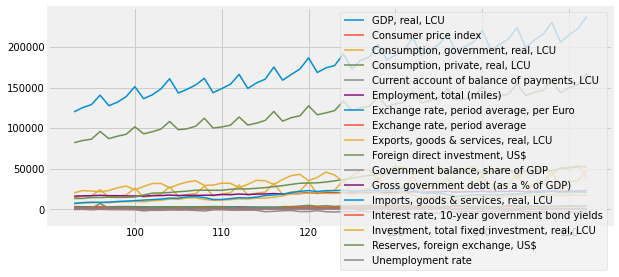

In [38]:
fig, ax = plt.subplots(figsize=(9, 4))
dfm["PIB"].plot(ax=ax, label="GDP, real, LCU")
x.plot(ax=ax, label='exogenous variable')
ax.legend();

##Normalización Multivariado

In [39]:
adf1= adfuller(SerieTiempom["PIB"], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -0.9858098125117623
el p-value es: 0.758404597715459
valores criticos: {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}


In [40]:
SerieTiempom ["LPIB"] = np.log(SerieTiempom ["PIB"])
SerieTiempom ["DLPIB"] = SerieTiempom ["LPIB"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,PIB,"Government balance, share of GDP",Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate,LPIB,DLPIB
date,,,,,,,,,,,,,,,,,,,,,
2005-04-01,2005,2,57.950000,15837.376789,84637.764901,-285.264054,16344.090000,2949.050667,2340.340000,7718.999296,...,125296.345675,0.025854,47.948173,8004.263350,13.111201,22885.203418,13151.785689,12.020280,11.738437,0.043178
2005-07-01,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,...,128934.308843,-0.008476,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390,11.767058,0.028621
2005-10-01,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,...,140620.945199,-0.002514,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057,11.853823,0.086765
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,...,127587.214775,-0.010241,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233,11.756555,-0.097268
2006-04-01,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,...,131941.288576,0.017964,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286,11.790112,0.033557


In [41]:
adf1= adfuller(SerieTiempom['Consumer price index'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: 0.4676254130661222
el p-value es: 0.9838551607848507
valores criticos: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


In [42]:
SerieTiempom['LIPC'] = np.log(SerieTiempom['Consumer price index'])
SerieTiempom["DLIPC"] = SerieTiempom["LIPC"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,Gross government debt (as a % of GDP),"Imports, goods & services, real, LCU","Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate,LPIB,DLPIB,LIPC,DLIPC
date,,,,,,,,,,,,,,,,,,,,,
2005-07-01,2005,3,58.293333,16499.735215,86317.968415,-877.337521,16560.042000,2817.093920,2308.030000,7701.084882,...,48.518970,8578.422403,10.356994,22301.131148,14309.044114,11.740390,11.767058,0.028621,4.065488,0.005907
2005-10-01,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,...,50.438074,8291.677475,9.467070,21479.469702,14325.609046,10.285057,11.853823,0.086765,4.071644,0.006157
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,...,45.747144,8607.172463,7.822868,22922.144786,14681.012969,12.601233,11.756555,-0.097268,4.084631,0.012986
2006-04-01,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,...,47.786706,9430.597781,9.961104,26332.752581,14396.702466,11.686286,11.790112,0.033557,4.099111,0.014480
2006-07-01,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,...,47.178122,9902.757739,9.653961,28442.963092,14567.834020,12.746544,11.840937,0.050825,4.109944,0.010834


In [43]:
adf1= adfuller(SerieTiempom['Consumption, government, real, LCU'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto es estacionario, solo se aplica log

el t-test es: -2.701291187380437
el p-value es: 0.0738151036174504
valores criticos: {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}


In [44]:
SerieTiempom['LCG'] = np.log(SerieTiempom['Consumption, government, real, LCU'])
SerieTiempom["DLCG"] = SerieTiempom["LCG"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,"Interest rate, 10-year government bond yields","Investment, total fixed investment, real, LCU","Reserves, foreign exchange, US$",Unemployment rate,LPIB,DLPIB,LIPC,DLIPC,LCG,DLCG
date,,,,,,,,,,,,,,,,,,,,,
2005-10-01,2005,4,58.653333,23904.889336,95814.080666,-233.634088,17047.117333,2715.529299,2283.770000,8058.043387,...,9.467070,21479.469702,14325.609046,10.285057,11.853823,0.086765,4.071644,0.006157,10.081838,0.370739
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,...,7.822868,22922.144786,14681.012969,12.601233,11.756555,-0.097268,4.084631,0.012986,9.600839,-0.480999
2006-04-01,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,...,9.961104,26332.752581,14396.702466,11.686286,11.790112,0.033557,4.099111,0.014480,9.687578,0.086739
2006-07-01,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,...,9.653961,28442.963092,14567.834020,12.746544,11.840937,0.050825,4.109944,0.010834,9.761905,0.074327
2006-10-01,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,...,9.183083,23707.139541,15014.361958,11.396815,11.925605,0.084668,4.113984,0.004039,10.157781,0.395876


In [45]:
adf1= adfuller(SerieTiempom['Consumption, private, real, LCU'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -0.6898815730719675
el p-value es: 0.8493530586371755
valores criticos: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}


In [46]:
SerieTiempom['LCP'] = np.log(SerieTiempom['Consumption, private, real, LCU'])
SerieTiempom["DLCP"] = SerieTiempom["LCP"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,"Reserves, foreign exchange, US$",Unemployment rate,LPIB,DLPIB,LIPC,DLIPC,LCG,DLCG,LCP,DLCP
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,2006,1,59.420000,14777.179307,86982.686822,-669.340444,16551.336333,2723.491234,2264.086667,7937.832019,...,14681.012969,12.601233,11.756555,-0.097268,4.084631,0.012986,9.600839,-0.480999,11.373464,-0.096701
2006-04-01,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,...,14396.702466,11.686286,11.790112,0.033557,4.099111,0.014480,9.687578,0.086739,11.407587,0.034123
2006-07-01,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,...,14567.834020,12.746544,11.840937,0.050825,4.109944,0.010834,9.761905,0.074327,11.433651,0.026064
2006-10-01,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,...,15014.361958,11.396815,11.925605,0.084668,4.113984,0.004039,10.157781,0.395876,11.528697,0.095046
2007-01-01,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,...,17350.077332,13.050369,11.822344,-0.103261,4.135806,0.021823,9.608169,-0.549612,11.440066,-0.088632


In [47]:
adf1= adfuller(SerieTiempom['Current account of balance of payments, LCU'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto es estacionario sacamos log

el t-test es: -2.0053782281473156
el p-value es: 0.28421992399972384
valores criticos: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


In [48]:
SerieTiempom['LCCTE'] = np.log((SerieTiempom['Current account of balance of payments, LCU']*(-1)))
SerieTiempom["DLCCTE"] = SerieTiempom["LCCTE"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LPIB,DLPIB,LIPC,DLIPC,LCG,DLCG,LCP,DLCP,LCCTE,DLCCTE
date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,2006,2,60.286667,16116.161725,90001.976171,-707.381244,16601.566667,3058.913088,2431.506667,8723.216537,...,11.790112,0.033557,4.099111,0.014480,9.687578,0.086739,11.407587,0.034123,6.561570,0.055277
2006-07-01,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,...,11.840937,0.050825,4.109944,0.010834,9.761905,0.074327,11.433651,0.026064,6.652884,0.091315
2006-10-01,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,...,11.925605,0.084668,4.113984,0.004039,10.157781,0.395876,11.528697,0.095046,6.732537,0.079652
2007-01-01,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,...,11.822344,-0.103261,4.135806,0.021823,9.608169,-0.549612,11.440066,-0.088632,7.645555,0.913018
2007-04-01,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,...,11.856483,0.034140,4.158987,0.023181,9.711108,0.102939,11.465410,0.025344,7.281823,-0.363731


In [49]:
adf1= adfuller(SerieTiempom['Employment, total (miles)'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -1.0214441584608287
el p-value es: 0.7453629125210538
valores criticos: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


In [50]:
SerieTiempom['LEMP'] = np.log(SerieTiempom['Employment, total (miles)'])
SerieTiempom["DLEMP"] = SerieTiempom["LEMP"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LIPC,DLIPC,LCG,DLCG,LCP,DLCP,LCCTE,DLCCTE,LEMP,DLEMP
date,,,,,,,,,,,,,,,,,,,,,
2006-07-01,2006,3,60.943333,17359.663336,92378.667646,-775.016625,16258.391618,3103.066830,2433.423333,9127.741113,...,4.109944,0.010834,9.761905,0.074327,11.433651,0.026064,6.652884,0.091315,9.696364,-0.020888
2006-10-01,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,...,4.113984,0.004039,10.157781,0.395876,11.528697,0.095046,6.732537,0.079652,9.693040,-0.003324
2007-01-01,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,...,4.135806,0.021823,9.608169,-0.549612,11.440066,-0.088632,7.645555,0.913018,9.681506,-0.011535
2007-04-01,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,...,4.158987,0.023181,9.711108,0.102939,11.465410,0.025344,7.281823,-0.363731,9.719307,0.037802
2007-07-01,2007,3,64.190000,18447.022832,98758.543476,-1462.853630,16655.760635,2805.001687,2042.066667,10902.952704,...,4.161847,0.002860,9.822658,0.111550,11.500433,0.035024,7.288144,0.006321,9.720511,0.001204


In [51]:
adf1= adfuller(SerieTiempom['Exchange rate, period average, per Euro'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -0.39496632892143974
el p-value es: 0.9109358338221064
valores criticos: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


In [52]:
SerieTiempom['LTRMEUR'] = np.log(SerieTiempom['Exchange rate, period average, per Euro'])
SerieTiempom["DLTRMEUR"] = SerieTiempom["LTRMEUR"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LCG,DLCG,LCP,DLCP,LCCTE,DLCCTE,LEMP,DLEMP,LTRMEUR,DLTRMEUR
date,,,,,,,,,,,,,,,,,,,,,
2006-10-01,2006,4,61.190000,25790.995631,101589.669361,-839.273489,16204.437934,2973.526807,2305.361754,9593.472721,...,10.157781,0.395876,11.528697,0.095046,6.732537,0.079652,9.693040,-0.003324,7.997504,-0.042642
2007-01-01,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,...,9.608169,-0.549612,11.440066,-0.088632,7.645555,0.913018,9.681506,-0.011535,7.976598,-0.020906
2007-04-01,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,...,9.711108,0.102939,11.465410,0.025344,7.281823,-0.363731,9.719307,0.037802,7.912876,-0.063723
2007-07-01,2007,3,64.190000,18447.022832,98758.543476,-1462.853630,16655.760635,2805.001687,2042.066667,10902.952704,...,9.822658,0.111550,11.500433,0.035024,7.288144,0.006321,9.720511,0.001204,7.939159,0.026284
2007-10-01,2007,4,64.510000,27594.219234,108169.813746,-1141.795167,17309.180765,2927.998873,2021.727167,12395.159363,...,10.225362,0.402703,11.591458,0.091024,7.040357,-0.247787,9.758992,0.038481,7.982074,0.042915


In [53]:
adf1= adfuller(SerieTiempom['Exchange rate, period average'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -0.3734982979756848
el p-value es: 0.9144304661113465
valores criticos: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}


In [54]:
SerieTiempom['LTRM'] = np.log(SerieTiempom['Exchange rate, period average'])
SerieTiempom["DLTRM"] = SerieTiempom["LTRM"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LCP,DLCP,LCCTE,DLCCTE,LEMP,DLEMP,LTRMEUR,DLTRMEUR,LTRM,DLTRM
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007,1,62.540000,14885.883154,92973.106818,-2091.328497,16018.596198,2912.008060,2222.026667,9021.832594,...,11.440066,-0.088632,7.645555,0.913018,9.681506,-0.011535,7.976598,-0.020906,7.706175,-0.036818
2007-04-01,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,...,11.465410,0.025344,7.281823,-0.363731,9.719307,0.037802,7.912876,-0.063723,7.613534,-0.092641
2007-07-01,2007,3,64.190000,18447.022832,98758.543476,-1462.853630,16655.760635,2805.001687,2042.066667,10902.952704,...,11.500433,0.035024,7.288144,0.006321,9.720511,0.001204,7.939159,0.026284,7.621718,0.008184
2007-10-01,2007,4,64.510000,27594.219234,108169.813746,-1141.795167,17309.180765,2927.998873,2021.727167,12395.159363,...,11.591458,0.091024,7.040357,-0.247787,9.758992,0.038481,7.982074,0.042915,7.611707,-0.010010
2008-01-01,2008,1,66.350000,15760.996749,98012.025588,-1312.289157,16767.124623,2863.789639,1910.253333,12052.558103,...,11.492845,-0.098612,7.179528,0.139171,9.727175,-0.031817,7.959901,-0.022173,7.554991,-0.056716


In [55]:
adf1= adfuller(SerieTiempom['Exports, goods & services, real, LCU'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto  es estacionario, sacamos log

el t-test es: -2.2322803760110452
el p-value es: 0.19473879212726836
valores criticos: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}


In [56]:
SerieTiempom['LX'] = np.log(SerieTiempom['Exports, goods & services, real, LCU'])
SerieTiempom["DLX"] = SerieTiempom["LX"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LCCTE,DLCCTE,LEMP,DLEMP,LTRMEUR,DLTRMEUR,LTRM,DLTRM,LX,DLX
date,,,,,,,,,,,,,,,,,,,,,
2007-04-01,2007,2,64.006667,16499.874781,95359.535960,-1453.636263,16635.714112,2732.236198,2025.423333,10233.611701,...,7.281823,-0.363731,9.719307,0.037802,7.912876,-0.063723,7.613534,-0.092641,9.233433,0.126030
2007-07-01,2007,3,64.190000,18447.022832,98758.543476,-1462.853630,16655.760635,2805.001687,2042.066667,10902.952704,...,7.288144,0.006321,9.720511,0.001204,7.939159,0.026284,7.621718,0.008184,9.296789,0.063356
2007-10-01,2007,4,64.510000,27594.219234,108169.813746,-1141.795167,17309.180765,2927.998873,2021.727167,12395.159363,...,7.040357,-0.247787,9.758992,0.038481,7.982074,0.042915,7.611707,-0.010010,9.425061,0.128272
2008-01-01,2008,1,66.350000,15760.996749,98012.025588,-1312.289157,16767.124623,2863.789639,1910.253333,12052.558103,...,7.179528,0.139171,9.727175,-0.031817,7.959901,-0.022173,7.554991,-0.056716,9.397032,-0.028029
2008-04-01,2008,2,68.126667,18036.451943,99072.385306,-1157.346771,17045.080978,2763.139519,1762.140000,13893.589839,...,7.053885,-0.125643,9.743617,0.016442,7.924123,-0.035778,7.474284,-0.080707,9.539183,0.142151


In [57]:
adf1= adfuller(SerieTiempom['Foreign direct investment, US$'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto no es estacionario, sacamos log

el t-test es: -4.2896276448213655
el p-value es: 0.0004629473252741639
valores criticos: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


In [58]:
SerieTiempom['LIED'] = np.log(SerieTiempom['Foreign direct investment, US$'])
SerieTiempom["DLIED"] = SerieTiempom["LIED"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LEMP,DLEMP,LTRMEUR,DLTRMEUR,LTRM,DLTRM,LX,DLX,LIED,DLIED
date,,,,,,,,,,,,,,,,,,,,,
2007-07-01,2007,3,64.190000,18447.022832,98758.543476,-1462.853630,16655.760635,2805.001687,2042.066667,10902.952704,...,9.720511,0.001204,7.939159,0.026284,7.621718,0.008184,9.296789,0.063356,7.751789,0.042599
2007-10-01,2007,4,64.510000,27594.219234,108169.813746,-1141.795167,17309.180765,2927.998873,2021.727167,12395.159363,...,9.758992,0.038481,7.982074,0.042915,7.611707,-0.010010,9.425061,0.128272,7.742844,-0.008945
2008-01-01,2008,1,66.350000,15760.996749,98012.025588,-1312.289157,16767.124623,2863.789639,1910.253333,12052.558103,...,9.727175,-0.031817,7.959901,-0.022173,7.554991,-0.056716,9.397032,-0.028029,7.907481,0.164638
2008-04-01,2008,2,68.126667,18036.451943,99072.385306,-1157.346771,17045.080978,2763.139519,1762.140000,13893.589839,...,9.743617,0.016442,7.924123,-0.035778,7.474284,-0.080707,9.539183,0.142151,7.760623,-0.146859
2008-07-01,2008,3,69.103333,18971.637164,102290.779621,-1661.075566,16985.424618,2844.090112,1897.806667,13803.164729,...,9.740111,-0.003506,7.952998,0.028876,7.548454,0.074170,9.532653,-0.006530,7.862486,0.101863


In [59]:
adf1= adfuller(SerieTiempom['Government balance, share of GDP'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto es estacionario

el t-test es: -8.14834562962855
el p-value es: 9.849016003261445e-13
valores criticos: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


In [60]:
SerieTiempom['LDGO'] = np.log(SerieTiempom['Government balance, share of GDP'])
SerieTiempom["DLDGO"] = SerieTiempom["LDGO"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LTRMEUR,DLTRMEUR,LTRM,DLTRM,LX,DLX,LIED,DLIED,LDGO,DLDGO
date,,,,,,,,,,,,,,,,,,,,,
2007-10-01,2007,4,64.510000,27594.219234,108169.813746,-1141.795167,17309.180765,2927.998873,2021.727167,12395.159363,...,7.982074,0.042915,7.611707,-0.010010,9.425061,0.128272,7.742844,-0.008945,NaN,NaN
2008-01-01,2008,1,66.350000,15760.996749,98012.025588,-1312.289157,16767.124623,2863.789639,1910.253333,12052.558103,...,7.959901,-0.022173,7.554991,-0.056716,9.397032,-0.028029,7.907481,0.164638,-3.498453,NaN
2008-04-01,2008,2,68.126667,18036.451943,99072.385306,-1157.346771,17045.080978,2763.139519,1762.140000,13893.589839,...,7.924123,-0.035778,7.474284,-0.080707,9.539183,0.142151,7.760623,-0.146859,-3.766630,-0.268177
2008-07-01,2008,3,69.103333,18971.637164,102290.779621,-1661.075566,16985.424618,2844.090112,1897.806667,13803.164729,...,7.952998,0.028876,7.548454,0.074170,9.532653,-0.006530,7.862486,0.101863,-4.145271,-0.378642
2008-10-01,2008,4,69.530000,28294.914145,112150.809484,-2366.559242,17113.171148,3017.698694,2290.350000,11885.447227,...,8.012250,0.059251,7.736460,0.188006,9.383070,-0.149583,7.973253,0.110767,NaN,NaN


In [61]:
adf1= adfuller(SerieTiempom['Gross government debt (as a % of GDP)'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario

el t-test es: -0.9151708827938053
el p-value es: 0.7829353825244223
valores criticos: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


In [62]:
SerieTiempom['LDFGOB'] = np.log(SerieTiempom['Gross government debt (as a % of GDP)'])
SerieTiempom["DLDFGOB"] = SerieTiempom["LDFGOB"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LTRM,DLTRM,LX,DLX,LIED,DLIED,LDGO,DLDGO,LDFGOB,DLDFGOB
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,2008,1,66.350000,15760.996749,98012.025588,-1312.289157,16767.124623,2863.789639,1910.253333,12052.558103,...,7.554991,-0.056716,9.397032,-0.028029,7.907481,0.164638,-3.498453,NaN,3.658714,-0.126814
2008-04-01,2008,2,68.126667,18036.451943,99072.385306,-1157.346771,17045.080978,2763.139519,1762.140000,13893.589839,...,7.474284,-0.080707,9.539183,0.142151,7.760623,-0.146859,-3.766630,-0.268177,3.674905,0.016190
2008-07-01,2008,3,69.103333,18971.637164,102290.779621,-1661.075566,16985.424618,2844.090112,1897.806667,13803.164729,...,7.548454,0.074170,9.532653,-0.006530,7.862486,0.101863,-4.145271,-0.378642,3.726322,0.051417
2008-10-01,2008,4,69.530000,28294.914145,112150.809484,-2366.559242,17113.171148,3017.698694,2290.350000,11885.447227,...,7.736460,0.188006,9.383070,-0.149583,7.973253,0.110767,NaN,NaN,3.758914,0.032592
2009-01-01,2009,1,70.720000,16418.782871,100017.080596,-932.176791,17150.304859,3140.795675,2414.643333,10904.008014,...,7.789307,0.052847,9.296886,-0.086184,7.736263,-0.236989,-5.871227,NaN,3.767075,0.008161


In [63]:
adf1= adfuller(SerieTiempom['Imports, goods & services, real, LCU'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto  es estacionario sacamos log

el t-test es: -1.7173312852281173
el p-value es: 0.4222057249662369
valores criticos: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}


In [64]:
SerieTiempom['LM'] = np.log(SerieTiempom['Imports, goods & services, real, LCU'])
SerieTiempom["DLM"] = SerieTiempom["LM"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LX,DLX,LIED,DLIED,LDGO,DLDGO,LDFGOB,DLDFGOB,LM,DLM
date,,,,,,,,,,,,,,,,,,,,,
2008-04-01,2008,2,68.126667,18036.451943,99072.385306,-1157.346771,17045.080978,2763.139519,1762.140000,13893.589839,...,9.539183,0.142151,7.760623,-0.146859,-3.766630,-0.268177,3.674905,0.016190,9.619196,0.118812
2008-07-01,2008,3,69.103333,18971.637164,102290.779621,-1661.075566,16985.424618,2844.090112,1897.806667,13803.164729,...,9.532653,-0.006530,7.862486,0.101863,-4.145271,-0.378642,3.726322,0.051417,9.646286,0.027090
2008-10-01,2008,4,69.530000,28294.914145,112150.809484,-2366.559242,17113.171148,3017.698694,2290.350000,11885.447227,...,9.383070,-0.149583,7.973253,0.110767,NaN,NaN,3.758914,0.032592,9.564653,-0.081633
2009-01-01,2009,1,70.720000,16418.782871,100017.080596,-932.176791,17150.304859,3140.795675,2414.643333,10904.008014,...,9.296886,-0.086184,7.736263,-0.236989,-5.871227,NaN,3.767075,0.008161,9.378917,-0.185736
2009-04-01,2009,2,71.373333,18620.416882,101390.033587,-760.919026,18012.745941,3036.788534,2233.116667,11103.073065,...,9.314977,0.018091,7.933685,0.197422,-4.068751,1.802477,3.745578,-0.021497,9.381263,0.002347


In [65]:
adf1= adfuller(SerieTiempom['Interest rate, 10-year government bond yields'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto  es estacionario 

el t-test es: -2.643464541308755
el p-value es: 0.08434257571732401
valores criticos: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}


In [66]:
SerieTiempom['LINT'] = np.log(SerieTiempom['Interest rate, 10-year government bond yields'])
SerieTiempom["DLINT"] = SerieTiempom["LINT"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LIED,DLIED,LDGO,DLDGO,LDFGOB,DLDFGOB,LM,DLM,LINT,DLINT
date,,,,,,,,,,,,,,,,,,,,,
2008-07-01,2008,3,69.103333,18971.637164,102290.779621,-1661.075566,16985.424618,2844.090112,1897.806667,13803.164729,...,7.862486,0.101863,-4.145271,-0.378642,3.726322,0.051417,9.646286,0.027090,2.484043,0.020984
2008-10-01,2008,4,69.530000,28294.914145,112150.809484,-2366.559242,17113.171148,3017.698694,2290.350000,11885.447227,...,7.973253,0.110767,NaN,NaN,3.758914,0.032592,9.564653,-0.081633,2.514864,0.030822
2009-01-01,2009,1,70.720000,16418.782871,100017.080596,-932.176791,17150.304859,3140.795675,2414.643333,10904.008014,...,7.736263,-0.236989,-5.871227,NaN,3.767075,0.008161,9.378917,-0.185736,2.299348,-0.215516
2009-04-01,2009,2,71.373333,18620.416882,101390.033587,-760.919026,18012.745941,3036.788534,2233.116667,11103.073065,...,7.933685,0.197422,-4.068751,1.802477,3.745578,-0.021497,9.381263,0.002347,2.251794,-0.047555
2009-07-01,2009,3,71.316667,20122.878319,103497.028282,-1296.268819,17797.668389,2881.521204,2017.473333,11658.782202,...,7.580235,-0.353450,NaN,NaN,3.726746,-0.018832,9.469241,0.087978,2.273352,0.021559


In [67]:
adf1= adfuller(SerieTiempom['Investment, total fixed investment, real, LCU'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto  es estacionario sacamos log

el t-test es: -2.5016697995585186
el p-value es: 0.11506857295296474
valores criticos: {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}


In [68]:
SerieTiempom['LI'] = np.log(SerieTiempom['Investment, total fixed investment, real, LCU'])
SerieTiempom["DLI"] = SerieTiempom["LI"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LDGO,DLDGO,LDFGOB,DLDFGOB,LM,DLM,LINT,DLINT,LI,DLI
date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,2008,4,69.530000,28294.914145,112150.809484,-2366.559242,17113.171148,3017.698694,2290.350000,11885.447227,...,NaN,NaN,3.758914,0.032592,9.564653,-0.081633,2.514864,0.030822,10.282254,-0.182434
2009-01-01,2009,1,70.720000,16418.782871,100017.080596,-932.176791,17150.304859,3140.795675,2414.643333,10904.008014,...,-5.871227,NaN,3.767075,0.008161,9.378917,-0.185736,2.299348,-0.215516,10.298115,0.015861
2009-04-01,2009,2,71.373333,18620.416882,101390.033587,-760.919026,18012.745941,3036.788534,2233.116667,11103.073065,...,-4.068751,1.802477,3.745578,-0.021497,9.381263,0.002347,2.251794,-0.047555,10.373519,0.075404
2009-07-01,2009,3,71.316667,20122.878319,103497.028282,-1296.268819,17797.668389,2881.521204,2017.473333,11658.782202,...,NaN,NaN,3.726746,-0.018832,9.469241,0.087978,2.273352,0.021559,10.366782,-0.006737
2009-10-01,2009,4,71.176667,29762.921928,113651.857535,-1443.640784,18593.927292,2901.573193,1965.160000,12662.813465,...,NaN,NaN,3.817716,0.090970,9.554388,0.085147,2.164224,-0.109128,10.187254,-0.179528


In [69]:
adf1= adfuller(SerieTiempom['Reserves, foreign exchange, US$'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es mayor a 0.5 por lo tanto no es estacionario 

el t-test es: -1.5935085914112306
el p-value es: 0.48685353947075144
valores criticos: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}


In [70]:
SerieTiempom['LRE'] = np.log(SerieTiempom['Reserves, foreign exchange, US$'])
SerieTiempom["DLRE"] = SerieTiempom["LRE"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LDFGOB,DLDFGOB,LM,DLM,LINT,DLINT,LI,DLI,LRE,DLRE
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,2009,1,70.720000,16418.782871,100017.080596,-932.176791,17150.304859,3140.795675,2414.643333,10904.008014,...,3.767075,0.008161,9.378917,-0.185736,2.299348,-0.215516,10.298115,0.015861,10.053450,-0.003659
2009-04-01,2009,2,71.373333,18620.416882,101390.033587,-760.919026,18012.745941,3036.788534,2233.116667,11103.073065,...,3.745578,-0.021497,9.381263,0.002347,2.251794,-0.047555,10.373519,0.075404,10.052265,-0.001184
2009-07-01,2009,3,71.316667,20122.878319,103497.028282,-1296.268819,17797.668389,2881.521204,2017.473333,11658.782202,...,3.726746,-0.018832,9.469241,0.087978,2.273352,0.021559,10.366782,-0.006737,10.104854,0.052589
2009-10-01,2009,4,71.176667,29762.921928,113651.857535,-1443.640784,18593.927292,2901.573193,1965.160000,12662.813465,...,3.817716,0.090970,9.554388,0.085147,2.164224,-0.109128,10.187254,-0.179528,10.125132,0.020278
2010-01-01,2010,1,72.143333,17243.406468,103710.606700,-1260.820266,18035.596584,2696.463573,1946.726667,12503.681521,...,3.758063,-0.059653,9.529848,-0.024539,2.244662,0.080438,10.327941,0.140687,10.125029,-0.000103


In [71]:
adf1= adfuller(SerieTiempom['Unemployment rate'], maxlag=1)
print("el t-test es:",adf1[0])
print("el p-value es:", adf1[1])
print("valores criticos:", adf1[4])
#p-value es menor a 0.5 por lo tanto  es estacionario 

el t-test es: -2.325548119023848
el p-value es: 0.1638605238106311
valores criticos: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}


In [72]:
SerieTiempom['LUN'] = np.log(SerieTiempom['Unemployment rate'])
SerieTiempom["DLUN"] = SerieTiempom["LUN"].diff()
SerieTiempom = SerieTiempom.drop(SerieTiempom.index[0])
SerieTiempom.head()

,year,quarter,Consumer price index,"Consumption, government, real, LCU","Consumption, private, real, LCU","Current account of balance of payments, LCU","Employment, total (miles)","Exchange rate, period average, per Euro","Exchange rate, period average","Exports, goods & services, real, LCU",...,LM,DLM,LINT,DLINT,LI,DLI,LRE,DLRE,LUN,DLUN
date,,,,,,,,,,,,,,,,,,,,,
2009-04-01,2009,2,71.373333,18620.416882,101390.033587,-760.919026,18012.745941,3036.788534,2233.116667,11103.073065,...,9.381263,0.002347,2.251794,-0.047555,10.373519,0.075404,10.052265,-0.001184,2.470192,-0.104691
2009-07-01,2009,3,71.316667,20122.878319,103497.028282,-1296.268819,17797.668389,2881.521204,2017.473333,11658.782202,...,9.469241,0.087978,2.273352,0.021559,10.366782,-0.006737,10.104854,0.052589,2.518499,0.048307
2009-10-01,2009,4,71.176667,29762.921928,113651.857535,-1443.640784,18593.927292,2901.573193,1965.160000,12662.813465,...,9.554388,0.085147,2.164224,-0.109128,10.187254,-0.179528,10.125132,0.020278,2.441171,-0.077328
2010-01-01,2010,1,72.143333,17243.406468,103710.606700,-1260.820266,18035.596584,2696.463573,1946.726667,12503.681521,...,9.529848,-0.024539,2.244662,0.080438,10.327941,0.140687,10.125029,-0.000103,2.578084,0.136913
2010-04-01,2010,2,72.870000,19660.234596,106060.122333,-1405.754743,18516.357014,2484.174289,1950.206667,13436.285004,...,9.605219,0.075371,2.153701,-0.090960,10.477613,0.149673,10.154451,0.029422,2.501814,-0.076270


##Ajuste del conjunto de entrenamiento y validación

In [73]:
x1 = SerieTiempom[['DLIPC','DLCG',	'DLCP',	'DLCCTE',	'DLEMP',	'DLTRMEUR',	'DLTRM',	'DLX',	'DLIED',	'DLDFGOB', 'DLM',	'DLINT',	'DLI',	'DLRE', 'DLUN']]
len(x1)
x1

,DLIPC,DLCG,DLCP,DLCCTE,DLEMP,DLTRMEUR,DLTRM,DLX,DLIED,DLDFGOB,DLM,DLINT,DLI,DLRE,DLUN
date,,,,,,,,,,,,,,,
2009-04-01,0.009196,0.125833,0.013634,-0.202996,0.049064,-0.033676,-0.078153,0.018091,0.197422,-0.021497,0.002347,-0.047555,0.075404,-0.001184,-0.104691
2009-07-01,-0.000794,0.077599,0.020568,0.532718,-0.012012,-0.052482,-0.101552,0.048838,-0.353450,-0.018832,0.087978,0.021559,-0.006737,0.052589,0.048307
2009-10-01,-0.001965,0.391406,0.093597,0.107678,0.043768,0.006935,-0.026272,0.082610,-0.676420,0.090970,0.085147,-0.109128,-0.179528,0.020278,-0.077328
2010-01-01,0.013490,-0.545834,-0.091536,-0.135406,-0.030488,-0.073312,-0.009424,-0.012647,0.190876,-0.059653,-0.024539,0.080438,0.140687,-0.000103,0.136913
2010-04-01,0.010022,0.131168,0.022402,0.108812,0.026307,-0.082001,0.001786,0.071936,0.478273,0.010254,0.075371,-0.090960,0.149673,0.029422,-0.076270
2010-07-01,0.000960,0.064179,0.031332,0.825805,0.010787,-0.047156,-0.061949,0.002339,0.188615,-0.003932,0.116632,-0.097862,-0.013420,0.030796,-0.045249
2010-10-01,0.002054,0.407083,0.096291,-0.170876,0.024144,0.066571,0.017809,0.101988,-0.925391,0.066723,0.054931,0.022862,-0.142712,0.043208,-0.074782
2011-01-01,0.018929,-0.554837,-0.104763,-0.300875,-0.026957,0.014207,0.006346,0.091357,1.207258,-0.157606,0.040243,0.088299,0.185172,0.045824,0.151617
2011-04-01,0.007934,0.152013,0.038790,-0.148758,0.024458,0.007250,-0.042918,0.136205,-0.003097,-0.024066,0.108756,-0.052644,0.122724,0.050311,-0.115992


In [74]:
y1=SerieTiempom[["DLPIB"]]
len(y1)

43

In [75]:
print(f'Number of rows with missing values: {x1.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [76]:
print(f'Number of rows with missing values: {y1.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [77]:
# Split data into train-test
# ==============================================================================
steps = 12
data_trainm= SerieTiempom[:-steps]
data_testm = SerieTiempom[-steps:]

print(f"Train dates : {data_trainm.index.min()} --- {data_trainm.index.max()}  (n={len(data_trainm)})")
print(f"Test dates  : {data_testm.index.min()} --- {data_testm.index.max()}  (n={len(data_testm)})")

Train dates : 2009-04-01 00:00:00 --- 2016-10-01 00:00:00  (n=31)
Test dates  : 2017-01-01 00:00:00 --- 2019-10-01 00:00:00  (n=12)


**Entrenamiento**

In [82]:
# Create and train forecaster
# ==============================================================================
forecasterm = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=42),
                lags      = 5
             )

forecasterm.fit(
    y   = data_trainm['DLPIB'].asfreq('QS'), 
    exog = data_trainm [['DLIPC','DLCG',	'DLCP',	'DLCCTE',	'DLEMP',	'DLTRMEUR',	'DLTRM',	'DLX',	'DLIED',	'DLDFGOB', 'DLM',	'DLINT',	'DLI',	'DLRE', 'DLUN']].asfreq('QS')
    )
forecasterm

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [1 2 3 4 5] 
Window size: 5 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['DLIPC', 'DLCG', 'DLCP', 'DLCCTE', 'DLEMP', 'DLTRMEUR', 'DLTRM', 'DLX', 'DLIED', 'DLDFGOB', 'DLM', 'DLINT', 'DLI', 'DLRE', 'DLUN'] 
Training range: [Timestamp('2009-04-01 00:00:00'), Timestamp('2016-10-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: QS-JAN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-22 06:37:57 
Last fit date: 2022-08-22 06:37:57 
Skforecast ve

In [83]:
# Predictions
# ==============================================================================
predictionsm = forecasterm.predict(steps=steps, 
                                 exog=data_testm[['DLIPC','DLCG',	'DLCP',	'DLCCTE',	'DLEMP',	'DLTRMEUR',	'DLTRM',	'DLX',	'DLIED',	'DLDFGOB', 'DLM',	'DLINT',	'DLI',	'DLRE', 'DLUN']].asfreq('QS'))

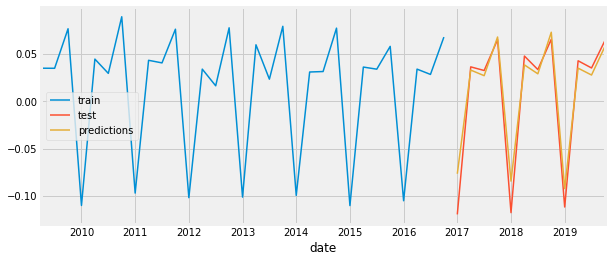

In [84]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_trainm['DLPIB'].plot(ax=ax, label='train')
data_testm['DLPIB'].plot(ax=ax, label='test')
predictionsm.plot(ax=ax, label='predictions')
ax.legend();

**Medidas de bondad de ajuste**

In [85]:
# Test error
# ==============================================================================
error_msem = mean_squared_error(
                y_true = data_testm['DLPIB'],
                y_pred = predictionsm
            )

print(f"Test error (mse): {error_msem}")

Test error (mse): 0.0003077008469829387


In [86]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmsm = sqrt(mean_squared_error(y_true=data_testm['DLPIB'], y_pred= predictionsm))
print(f"root mean squared error (rms): {rmsm}")

root mean squared error (rms): 0.017541403791684937


In [87]:
from sklearn.metrics import mean_absolute_error

maem = mean_absolute_error(y_true=data_testm['DLPIB'], y_pred= predictionsm)
print(f"mean absolute error (mae): {maem}")

mean absolute error (mae): 0.01248938772019286


**Regresar a las variables originales**

In [88]:
ori_predm = np.r_[data_trainm['LPIB'][-1], predictionsm].cumsum()
exp_ori_predm = np.exp(ori_predm)
data_testm['predfecha']=exp_ori_predm[:-1] 
print(data_testm['predfecha'])


date
2017-01-01    220751.546169
2017-04-01    204466.749644
2017-07-01    211295.849357
2017-10-01    217064.805831
2018-01-01    232282.533960
2018-04-01    213480.503519
2018-07-01    221819.980324
2018-10-01    228325.241699
2019-01-01    245569.701765
2019-04-01    223908.504504
2019-07-01    231853.986060
2019-10-01    238346.613357
Name: predfecha, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


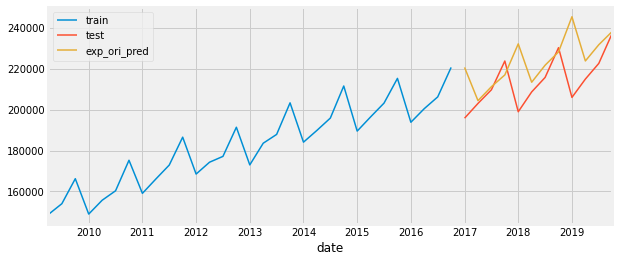

In [89]:
fig, ax = plt.subplots(figsize=(9, 4))
data_trainm['PIB'].plot(ax=ax, label='train')
data_testm['PIB'].plot(ax=ax, label='test')
data_testm['predfecha'].plot(ax=ax, label='exp_ori_pred')
ax.legend();

**Ajuste de hiperparámetros**

In [90]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecastermh = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=42),
                lags      = 6 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_gridmh = [5, 10]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [1,3,7,11,17,19]}

results_gridmh = grid_search_forecaster(
                        forecaster         = forecastermh,
                        y                  = data_trainu['DLPIB'],
                        param_grid         = param_grid,
                        lags_grid          = lags_gridmh,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_trainu)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 36


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:35<00:00, 47.91s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 7, 'n_estimators': 100}
  Backtesting metric: 0.00023811346833089455



In [92]:
results_gridmh

,lags,params,metric,max_depth,n_estimators
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 100}",0.000238,7,100
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 19, 'n_estimators': 100}",0.000244,19,100
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 11, 'n_estimators': 100}",0.000244,11,100
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 17, 'n_estimators': 100}",0.000244,17,100
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 19, 'n_estimators': 1000}",0.000245,19,1000
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 17, 'n_estimators': 1000}",0.000245,17,1000
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 11, 'n_estimators': 1000}",0.000245,11,1000
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 1000}",0.000246,7,1000
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.000250,3,100
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 1000}",0.000258,3,1000


**Predicción con hiperparámetros**

In [94]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressormh = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=44)
forecastermh = ForecasterAutoreg(
                regressor = regressormh,
                lags      = 10
             )

forecastermh.fit(y=data_trainm['DLPIB'].asfreq('QS'))

In [95]:
# Predictions
# ==============================================================================
predictionsmh = forecastermh.predict(steps=steps)

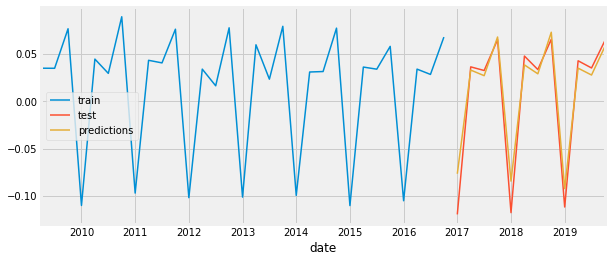

In [96]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_trainm['DLPIB'].plot(ax=ax, label='train')
data_testm['DLPIB'].plot(ax=ax, label='test')
predictionsm.plot(ax=ax, label='predictions')
ax.legend();

In [97]:
# Test error
# ==============================================================================
error_msemh = mean_squared_error(
                y_true = data_testm['DLPIB'],
                y_pred = predictionsmh
                )

print(f"Test error (mse): {error_msemh}")

Test error (mse): 0.0005478235138358602


In [98]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmsmh = sqrt(mean_squared_error(y_true=data_testm['DLPIB'], y_pred= predictionsmh))
print(f"root mean squared error (rms): {rmsmh}")

root mean squared error (rms): 0.023405629960243757


In [99]:
from sklearn.metrics import mean_absolute_error

maemh = mean_absolute_error(y_true=data_testm['DLPIB'], y_pred= predictionsmh)
print(f"mean absolute error (maemh): {maemh}")

mean absolute error (maemh): 0.015831021512338294
